In [1]:
from src.data import RawDataset, Dataset
from src.utils import list_dir, head_file, load_json, save_json
from src import workflow

import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create Raw Dataset

In [4]:
raw_ds = RawDataset("fremont_bike")

In [5]:
raw_ds.add_url(url="https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD", file_name="fremont.csv")

In [6]:
license_txt = "Public Domain"

readme_txt = """
Fremont Bridge Hourly Bicycle Counts by Month October 2012 to present

The Dataset is provided by the Seattle Department of Transportation Open Data initiative and is available from:
https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k

Description
-----------
The Fremont Bridge Bicycle Counter records the number of bikes that cross the bridge using the 
pedestrian/bicycle pathways. Inductive loops on the east and west pathways count the passing of bicycles 
regardless of travel direction. The data consists of a date/time field: Date, east pathway count field: 
Fremont Bridge NB, and west pathway count field: Fremont Bridge SB. The count fields represent the 
total bicycles detected during the specified one hour period. Direction of travel is not specified, 
but in general most traffic in the Fremont Bridge NB field is travelling northbound and most traffic in
the Fremont Bridge SB field is travelling southbound.

Data Format
-----------
The Dataset consists of a csv file with three columns:
  Date, Fremont Bridge East Sidewalk, Fremont Bridge West Sidewalk
Data consist of counts (in each direction) grouped by hour.

"""


In [7]:
raw_ds.add_metadata(contents=license_txt, kind='LICENSE')
raw_ds.add_metadata(contents=readme_txt, kind='DESCR')

In [29]:
raw_ds.fetch()

2018-10-13 14:04:45,642 - fetch - DEBUG - fremont.csv exists, but no hash to check. Setting to sha1:1f4226ac7445d955ea1e5bad469be07bafb5c511
2018-10-13 14:04:45,643 - fetch - DEBUG - Creating fremont_bike.license from `contents` string
2018-10-13 14:04:45,644 - fetch - DEBUG - fremont_bike.license exists, but no hash to check. Setting to sha1:b95d961276d9e9809aec43b99dd04ac1d017c6fc
2018-10-13 14:04:45,645 - fetch - DEBUG - Creating fremont_bike.readme from `contents` string
2018-10-13 14:04:45,648 - fetch - DEBUG - fremont_bike.readme exists, but no hash to check. Setting to sha1:4f18f5ff4f45776986f865897db6c7fab5ceed2d


True

In [8]:
# What do we have?
unpack_dir = raw_ds.unpack()
print(unpack_dir)
list_dir(unpack_dir)

2018-10-13 14:06:42,653 - datasets - DEBUG - unpack() called before fetch()
2018-10-13 14:06:42,659 - fetch - DEBUG - fremont.csv exists, but no hash to check. Setting to sha1:1f4226ac7445d955ea1e5bad469be07bafb5c511
2018-10-13 14:06:42,659 - fetch - DEBUG - Creating fremont_bike.license from `contents` string
2018-10-13 14:06:42,662 - fetch - DEBUG - fremont_bike.license exists, but no hash to check. Setting to sha1:b95d961276d9e9809aec43b99dd04ac1d017c6fc
2018-10-13 14:06:42,662 - fetch - DEBUG - Creating fremont_bike.readme from `contents` string
2018-10-13 14:06:42,664 - fetch - DEBUG - fremont_bike.readme exists, but no hash to check. Setting to sha1:4f18f5ff4f45776986f865897db6c7fab5ceed2d
2018-10-13 14:06:42,665 - fetch - DEBUG - Copying fremont.csv
2018-10-13 14:06:42,691 - fetch - DEBUG - Copying fremont_bike.license
2018-10-13 14:06:42,693 - fetch - DEBUG - Copying fremont_bike.readme


/Users/kjell/Documents/devel/git/bus_number/data/interim/fremont_bike


['fremont.csv',
 'fremont_bike.license',
 'fremont_bike.readme',
 'rows.csv?accessType=DOWNLOAD']

In [10]:
# Quick check of data format
print(head_file(unpack_dir / 'fremont.csv'))

Date,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
10/03/2012 12:00:00 AM,9,4
10/03/2012 01:00:00 AM,6,4
10/03/2012 02:00:00 AM,1,1
10/03/2012 03:00:00 AM,3,2
10/03/2012 04:00:00 AM,1,6



## Process data

In [100]:
import pandas as pd

In [101]:
# look at jvdp's example code. It basicall:
data = pd.read_csv(unpack_dir / 'fremont.csv', index_col='Date')

try:
    data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
except TypeError:
    data.index = pd.to_datetime(data.index)
data.columns = ['West', 'East']
data['Total'] = data['West'] + data['East']
data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,9.0,4.0,13.0
2012-10-03 01:00:00,6.0,4.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,3.0,2.0,5.0
2012-10-03 04:00:00,1.0,6.0,7.0


In [14]:
data = data.reset_index().values; data

array([[Timestamp('2012-10-03 00:00:00'), 9.0, 4.0, 13.0],
       [Timestamp('2012-10-03 01:00:00'), 6.0, 4.0, 10.0],
       [Timestamp('2012-10-03 02:00:00'), 1.0, 1.0, 2.0],
       ...,
       [Timestamp('2018-09-30 21:00:00'), 3.0, 4.0, 7.0],
       [Timestamp('2018-09-30 22:00:00'), 2.0, 7.0, 9.0],
       [Timestamp('2018-09-30 23:00:00'), 6.0, 4.0, 10.0]], dtype=object)

In [25]:
#%%file -a ../src/data/localdata.py
#__all__ += ['process_fremont_bike']
def process_fremont_bike(dataset_name="fremont_bike", metadata=None):
    """Process Seattle DoT's Fremont Bridge Hourly Bicycle Counts
    Data is available as a CSV.
    Parse into a pandas.Dataframe and add a total column
    """
    if metadata is None:
        metadata = {}
    data = pd.read_csv(interim_data_path / dataset_name / 'fremont.csv', index_col='Date')

    try:
        data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    except TypeError:
        data.index = pd.to_datetime(data.index)
    data.columns = ['West', 'East']
    data['Total'] = data['West'] + data['East']

    return {
        "dataset_name":dataset_name,
        "metadata": metadata,
        "data":data,
        "target":None
    }

Appending to ../src/data/localdata.py


In [10]:
from src.data import process_fremont_bike

In [11]:
raw_ds.load_function = process_fremont_bike

### Load the Raw Dataset

In [26]:
# Save the raw dataset
from src.data import Dataset
#add_raw_dataset(raw_ds)

workflow.add_raw_dataset(raw_ds)
workflow.available_raw_datasets()

['fremont_bike', 'lvq-pak']

In [27]:
#from src.paths import src_module_dir
#dataset_list_fq = src_module_dir / 'data' / 'datasets.json'
#dataset_list = load_json(dataset_list_fq)

# workflow.create_dataset(raw_dataset_name=raw_ds.name) 
workflow.available_datasets()

[]

In [28]:
workflow.get_transformer_list()
#dataset_list.append({"output_dataset":'fremont_bike', 'raw_dataset_name':'fremont_bike'})

[{'output_dataset': 'fremont_bike', 'raw_dataset_name': 'fremont_bike'}]

In [29]:
workflow.add_transformer(from_raw='fremont_bike')
workflow.get_transformer_list()

[{'output_dataset': 'fremont_bike', 'raw_dataset_name': 'fremont_bike'},
 {'output_dataset': 'fremont_bike', 'raw_dataset_name': 'fremont_bike'}]

In [30]:
workflow.del_transformer(-1)
workflow.get_transformer_list()

[{'output_dataset': 'fremont_bike', 'raw_dataset_name': 'fremont_bike'}]

In [31]:
!cd .. &&  make process_data

python3 -m src.data.apply_transforms transformer_list.json
2018-10-13 14:10:03,032 - apply_transforms - INFO - Transforming datasets from transformer_list.json
2018-10-13 14:10:03,062 - apply_transforms - INFO - Writing transformed Dataset: fremont_bike


In [32]:
workflow.available_datasets()

['fremont_bike']

## Work with the Dataset

In [19]:
ds = Dataset.load('fremont_bike')

In [20]:
ds.data.shape

(52536, 3)

In [21]:
type(ds.data)

pandas.core.frame.DataFrame

In [22]:
ds.data.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,9.0,4.0,13.0
2012-10-03 01:00:00,6.0,4.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,3.0,2.0,5.0
2012-10-03 04:00:00,1.0,6.0,7.0


In [31]:
### Create a transformer to pivot the data
#ds.data.pivot_table()
ds.data.index.time.shape

(52536,)

In [56]:
def index_to_date_time(dset, suffix='dt'):
    """Transformer: Extract a datetime index into Date and Time columns"""
    df = dset.data.copy()
    df['Time']=df.index.time
    df['Date']=df.index.date
    df.reset_index(inplace=True, drop=True)
    new_ds = Dataset(dataset_name=f"{dset.name}_{suffix}", metadata=dset.metadata, data=df)
    return new_ds

In [58]:
ds2 = index_to_date_time(ds)

In [60]:
# A transformer takes a dataset and returns a dataset
def pivot(dset, **pivot_opts):
    """Pivot data stored as a Pandas Dataframe
    
    pivot_opts:
        keyword arguments passed to pandas.Dataframe.pivot_table
    """
    pivoted = dset.data.pivot_table(i**pivot_opts)
    ds_pivot = Dataset(name=f"{dset.name}_pivoted", metadata=dset.metadata, data=pivoted, target=None)
    ds_pivot.metadata['pivot_opts'] = pivot_opts

    return ds_pivot


In [61]:
dsp = datetime_pivot(ds, values='Total')

In [20]:
dsp.data.shape

(24, 2189)

2018-10-12 21:26:58,673 - _base - DEBUG - update_title_pos
2018-10-12 21:26:58,682 - font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2018-10-12 21:26:58,695 - font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2018-10-12 21:26:59,224 - _base - DEBUG - update_title_pos
2018-10-12 21:26:59,746 - _base - DEBUG - update_title_pos
2018-10-12 21:27:00,319 - _base - DEBUG - update_title_pos
2018-10-12 21:27:00,692 - _base - DEBUG - update_title_pos


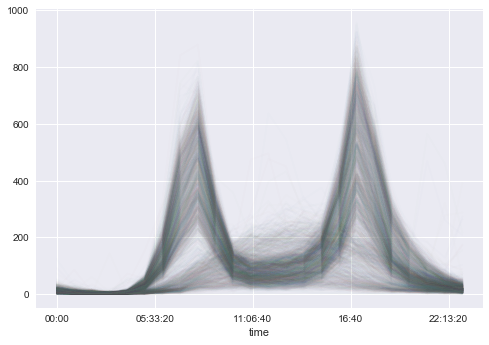

In [14]:
dsp.data.plot(legend=False, alpha=0.01);

In [23]:
from src.data.transformers import available_transformers

In [24]:
available_transformers().keys()

dict_keys(['datetime_pivot', 'index_to_date_time', 'pivot', 'train_test_split'])

In [43]:
from src.paths import src_module_dir

transform_pipeline = [
    ('index_to_date_time',{}),
    ('pivot', {'values':'Total', 'index':'Time', 'columns':'Date'})
]

workflow.add_transformer(from_raw="fremont_bike", output_dataset="fremont_bike_pivot", transformations=transform_pipeline)
workflow.add_transformer(input_dataset="fremont_bike", output_dataset="fremont_bike_pivot2", transformations=transform_pipeline)


In [44]:
workflow.get_transformer_list()

[{'output_dataset': 'fremont_bike', 'raw_dataset_name': 'fremont_bike'},
 {'output_dataset': 'fremont_bike_pivot',
  'raw_dataset_name': 'fremont_bike',
  'transformations': [['index_to_date_time', {}],
   ['pivot', {'columns': 'Date', 'index': 'Time', 'values': 'Total'}]]},
 {'input_dataset': 'fremont_bike',
  'output_dataset': 'fremont_bike_pivot2',
  'transformations': [['index_to_date_time', {}],
   ['pivot', {'columns': 'Date', 'index': 'Time', 'values': 'Total'}]]}]

In [48]:
!cd .. && make process_data

python3 -m src.data.apply_transforms transformer_list.json
2018-10-13 14:14:55,399 - apply_transforms - INFO - Transforming datasets from transformer_list.json
2018-10-13 14:14:55,454 - apply_transforms - INFO - Writing transformed Dataset: fremont_bike
2018-10-13 14:14:57,461 - apply_transforms - INFO - Writing transformed Dataset: fremont_bike_pivot
2018-10-13 14:14:59,447 - apply_transforms - INFO - Writing transformed Dataset: fremont_bike_pivot2


In [49]:
workflow.available_datasets()

['fremont_bike', 'fremont_bike_pivot', 'fremont_bike_pivot2']

In [50]:
dsp = Dataset.load('fremont_bike_pivot')
dsp.DATA_HASH

'2439f0389f64f726b1db03debbc15129821061b7'

In [52]:
dsp2 = Dataset.load('fremont_bike_pivot2')
dsp2.DATA_HASH

'2439f0389f64f726b1db03debbc15129821061b7'

2018-10-13 14:12:32,547 - _base - DEBUG - update_title_pos
2018-10-13 14:12:32,557 - font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2018-10-13 14:12:32,572 - font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('/Library/Fonts/Arial.ttf') with score of 0.050000.
2018-10-13 14:12:33,084 - _base - DEBUG - update_title_pos
2018-10-13 14:12:33,537 - _base - DEBUG - update_title_pos
2018-10-13 14:12:34,092 - _base - DEBUG - update_title_pos
2018-10-13 14:12:34,441 - _base - DEBUG - update_title_pos


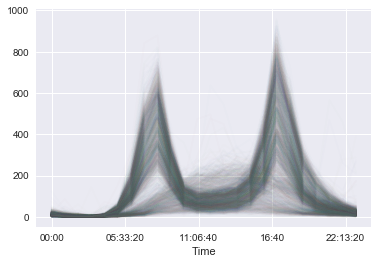

In [42]:
dsp.data.plot(legend=False, alpha=0.01);

In [32]:
dsp.data.shape

(24, 2189)